<a href="https://colab.research.google.com/github/SreeBhagya-S/TKM/blob/main/BERT_Mail_spam_classification_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
!pip install tensorflow_text
import tensorflow_text as text

     |████████████████████████████████| 4.9 MB 25.3 MB/s 
     |████████████████████████████████| 462 kB 44.5 MB/s 


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/TKM/references for review analysis/datasets/spam2.csv',encoding='cp1252')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [ ]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [ ]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [ ]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [ ]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [ ]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [ ]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
5204,ham,How come she can get it? Should b quite diff t...,0
2742,spam,I don't know u and u don't know me. Send CHAT ...,1
1866,ham,Call to the number which is available in appoi...,0
4412,ham,Ya but it cant display internal subs so i gott...,0
34,spam,Thanks for your subscription to Ringtone UK yo...,1


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [ ]:
X_train.head(4)

3630                 Should I head straight there or what
2420    SMS SERVICES For your inclusive text credits p...
5351    Yup it's at paragon... I havent decided whethe...
3067    Get a brand new mobile phone by being an agent...
Name: Message, dtype: object

In [ ]:
!pip install transformers

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
#model = ClassificationModel('bert', 'bert-base-multilingual-cased', num_labels=5, args={'preprocess_input_data': True, 'overwrite_output_dir': True}) 
# You can set class weights by using the optional weight argument

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 446s 12s/step - loss: 0.7093 - accuracy: 0.5482 - precision: 0.5504 - recall: 0.5268
Epoch 2/10
35/35 [==============================] - 435s 12s/step - loss: 0.5463 - accuracy: 0.7955 - precision: 0.7718 - recall: 0.8393
Epoch 3/10
35/35 [==============================] - 435s 12s/step - loss: 0.4609 - accuracy: 0.8509 - precision: 0.8406 - recall: 0.8661
Epoch 4/10
35/35 [==============================] - 436s 12s/step - loss: 0.4025 - accuracy: 0.8839 - precision: 0.8759 - recall: 0.8946
Epoch 5/10
35/35 [==============================] - 435s 12s/step - loss: 0.3775 - accuracy: 0.8741 - precision: 0.8656 - recall: 0.8857
Epoch 6/10
35/35 [==============================] - 435s 12s/step - loss: 0.3471 - accuracy: 0.8866 - precision: 0.8739 - recall: 0.9036
Epoch 7/10
35/35 [==============================] - 435s 12s/step - loss: 0.3244 - accuracy: 0.8911 - precision: 0.8763 - recall: 0.9107
Epoch 8/10
35/35 [=======================

In [ ]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 147s 12s/step - loss: 0.3187 - accuracy: 0.8850 - precision: 0.8600 - recall: 0.9198


[0.31866613030433655,
 0.885026752948761,
 0.8600000143051147,
 0.9197860956192017]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[159,  28],
       [ 15, 172]])

Text(33.0, 0.5, 'Truth')

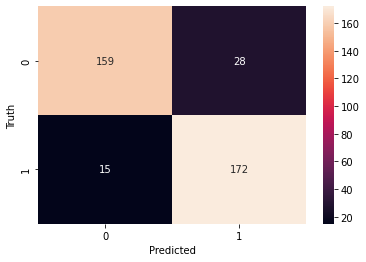

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       187
           1       0.86      0.92      0.89       187

    accuracy                           0.89       374
   macro avg       0.89      0.89      0.88       374
weighted avg       0.89      0.89      0.88       374



In [ ]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
m=model.predict(reviews)
r_predicted = np.where(m > 0.5, 'spam', 'ham')
r_predicted

array([['spam'],
       ['spam'],
       ['spam'],
       ['ham'],
       ['ham']], dtype='<U4')

In [ ]:
import numpy as np # linear algebra
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
tv=TfidfVectorizer(ngram_range=(2,2))
print(tv)
#cv = CountVectorizer(ngram_range=(2,2))
#print(cv)
"""  as we increase the ngram count, 
InTFIDF, there is a large fall in accuracy of  LR classifier and a relatively small change(decrease) in svm also
In CV also the accuracy decreases
TFIDF:::
ngram(1,1)-lr:87%, svm=88%      ngram(2,2)-lr=86.75%,svm=86.5%
ngram(1,10)-lr=82%, svm=86%     ngram(2.10)-lr=81.5%,svm=76.25%
CV:::
ngram(1,1)-lr=88%,svm=83%       ngram(2,2)-lr=83%,svm=81%
ngram(1,10-lr=83.5,svm=74.5)    ngram(2.10)-lr=81%,svm=70%
"""

TfidfVectorizer(ngram_range=(2, 2))


'  as we increase the ngram count, \nInTFIDF, there is a large fall in accuracy of  LR classifier and a relatively small change(decrease) in svm also\nIn CV also the accuracy decreases\nTFIDF:::\nngram(1,1)-lr:87%, svm=88%      ngram(2,2)-lr=86.75%,svm=86.5%\nngram(1,10)-lr=82%, svm=86%     ngram(2.10)-lr=81.5%,svm=76.25%\nCV:::\nngram(1,1)-lr=88%,svm=83%       ngram(2,2)-lr=83%,svm=81%\nngram(1,10-lr=83.5,svm=74.5)    ngram(2.10)-lr=81%,svm=70%\n'

In [ ]:
x_train=tv.fit_transform(X_train)
#print(x_train)

In [ ]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(max_iter=100000)
lr.fit(x_train,y_train)
pred_1=lr.predict(tv.transform(X_test))
#print(pred_1)

from sklearn.metrics import confusion_matrix
conf=confusion_matrix(y_test, pred_1)

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
data = {'y_Actual':y_test,'y_Predicted':pred_1}
dataset = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
conf_matrix = pd.crosstab(dataset['y_Actual'], dataset['y_Predicted'], rownames=['Actual'], colnames=['Predicted'],margins="TRUE")
print(conf_matrix)

Predicted    0    1  All
Actual                  
0          179    8  187
1           25  162  187
All        204  170  374


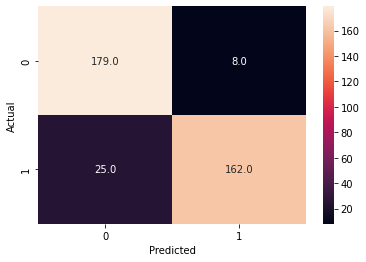


Using Logistic Regression, Accuracy=  0.9117647058823529


In [ ]:
data = {'y_Actual':y_test,'y_Predicted':pred_1}
dataset = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
conf_matrix_table = pd.crosstab(dataset['y_Actual'], dataset['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(conf_matrix_table, annot=True,fmt=".1f")
plt.show()

from sklearn.metrics import accuracy_score
score_1=accuracy_score(y_test,pred_1)
print("\nUsing Logistic Regression, Accuracy= ",score_1)

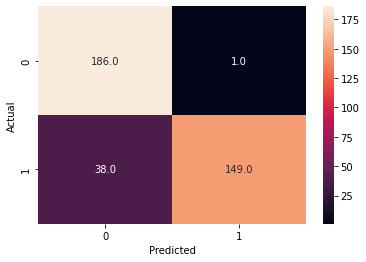


Using SVM, Accuracy=  0.8957219251336899


In [ ]:
from sklearn.svm import SVC
svm=SVC()
svm.fit(x_train,y_train)
pred_2=svm.predict(tv.transform(X_test))
score_2=accuracy_score(y_test,pred_2)
data = {'y_Actual':y_test,'y_Predicted':pred_2}
dataset = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
conf_matrix_table = pd.crosstab(dataset['y_Actual'], dataset['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(conf_matrix_table, annot=True,fmt=".1f")
plt.show()
print("\nUsing SVM, Accuracy= ",score_2)

In [ ]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(max_iter=100000)
lr.fit(x_train,y_train)
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
#x_test=["hi how are you","I had originally chosen the Conrad Chicago Hotel for its location near shopping centers that were within walking distance. ","nice food","bad room","what r u speaking"]
pred_1=lr.predict(tv.transform(reviews))
r_predicted = np.where(pred_1> 0.5, 'spam', 'ham')
r_predicted

array(['spam', 'spam', 'spam', 'ham', 'ham'], dtype='<U4')